In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from fixpoint_utils import (
    keypoints_IoU_mult,
    get_acc,
    get_acc_EfficentNet, 
    save_checkpoint, 
    load_checkpoint, 
    get_loader_keypoint,
    plot_keypoints_IoU)

from torchvision.ops import (
    masks_to_boxes,
    generalized_box_iou
)
import matplotlib.patches as patches

from Keypoint_dataset import Keypoint_dataset
from torch.optim.lr_scheduler import StepLR
from models_2 import ResNet, BasicBlock, KeypointModel, KeypointCNN, EfficentNet, EfficentNet_3, UNET

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# HYPERPARAMETERS:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOGGING = False
NUM_EPOCHS = 100
random.seed(42)
torch.manual_seed(42)

In [3]:
train_loader, test_loader = get_loader_keypoint(BATCH_SIZE = 1)

In [4]:
transform_test_padding = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.CropAndPad(px = 40, keep_size=True),
        #A.Normalize(mean = (162,), std= (44,), max_pixel_value=1.0),
        ToTensorV2(),
    ],
    keypoint_params=A.KeypointParams(format='xy')
)


df_path = r'/home/alex/Documents/new try/Data/Studie_daten/Study_data.csv'
df = pd.read_csv(df_path, sep = ';')
_, test_indices = train_test_split(df.index, test_size=0.3, random_state=42)
test_df = df.loc[test_indices].sample(10).reset_index(drop = True)

test_keypoint_ds = Keypoint_dataset(test_df,
                    transform= transform_test_padding)  

random_loader = DataLoader(test_keypoint_ds,
                          batch_size= 1,
                          num_workers= 0,
                          pin_memory= False,
                          shuffle= False)

# Evaluation

In [5]:
EffNet = EfficentNet().to(DEVICE)
Keyp = KeypointModel().to(DEVICE)
checkpoint_EffNet = r'/home/alex/Documents/new try/Data/Studie_daten/safe_states/EfficentNet_padding_0.001_1_1_0.pth.tar'
checkpoint_Keyp = r'/home/alex/Documents/new try/Data/Studie_daten/safe_states/Keypoint_detection_padding_0.001_1_0_6.pth.tar'
load_checkpoint(EffNet, checkpoint_EffNet)
load_checkpoint(Keyp, checkpoint_Keyp)

=> Loading checkpoint
=> Loading checkpoint


/tmp/ipykernel_393912/2136419728.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


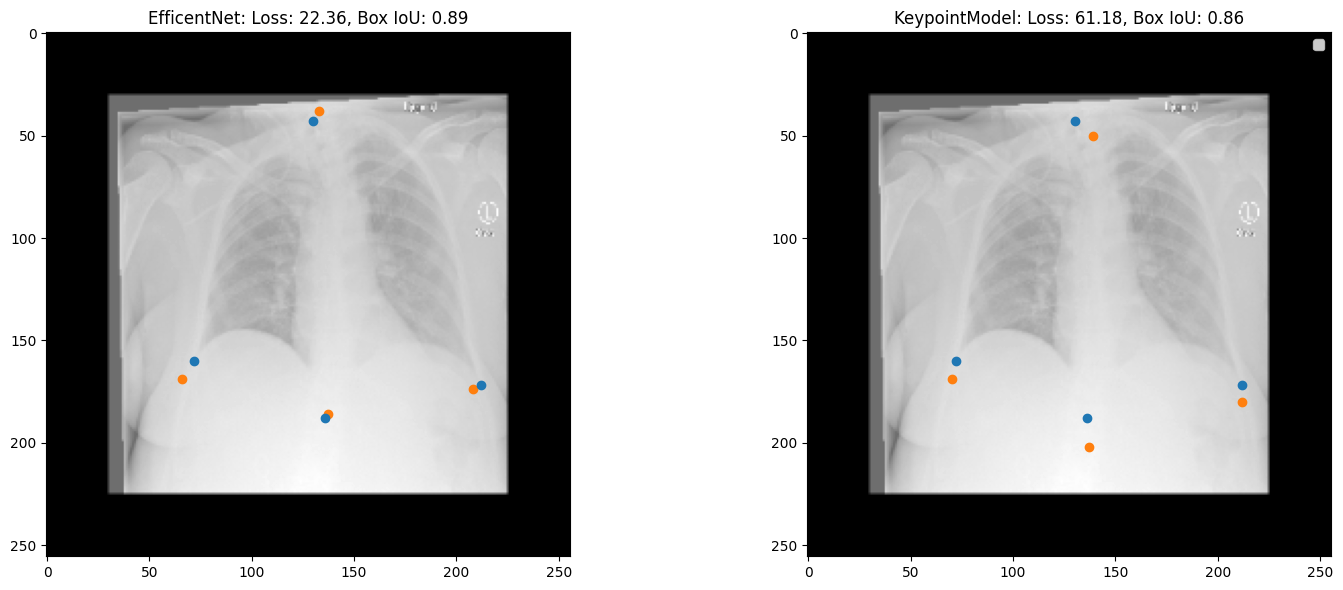

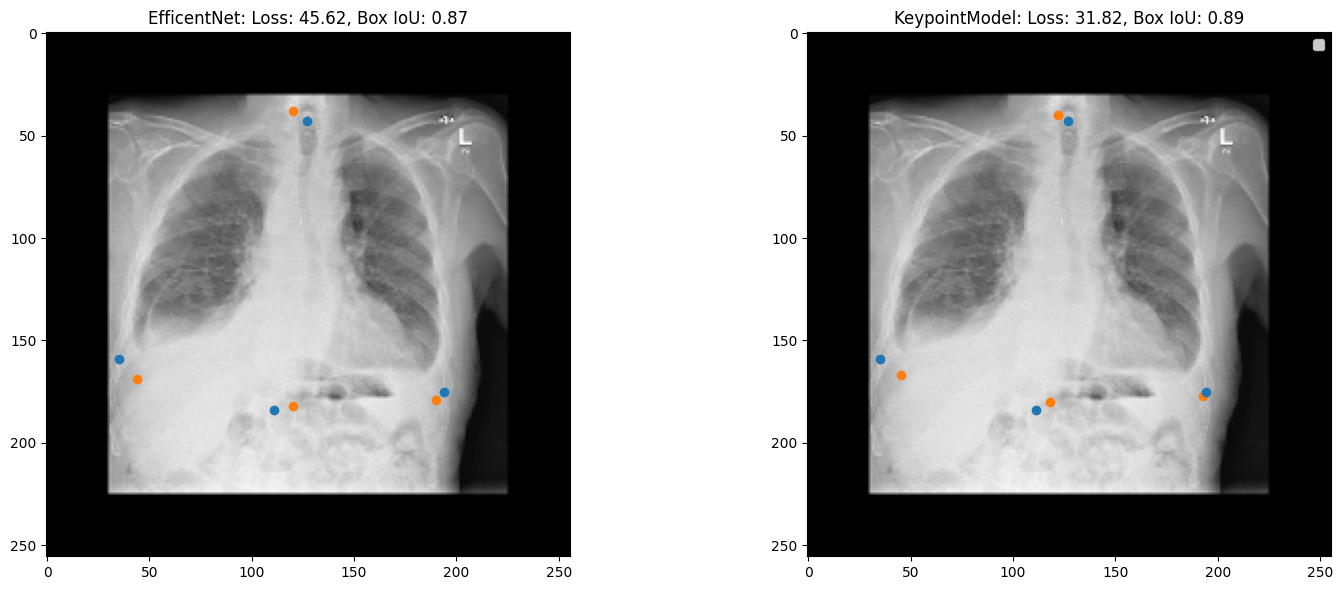

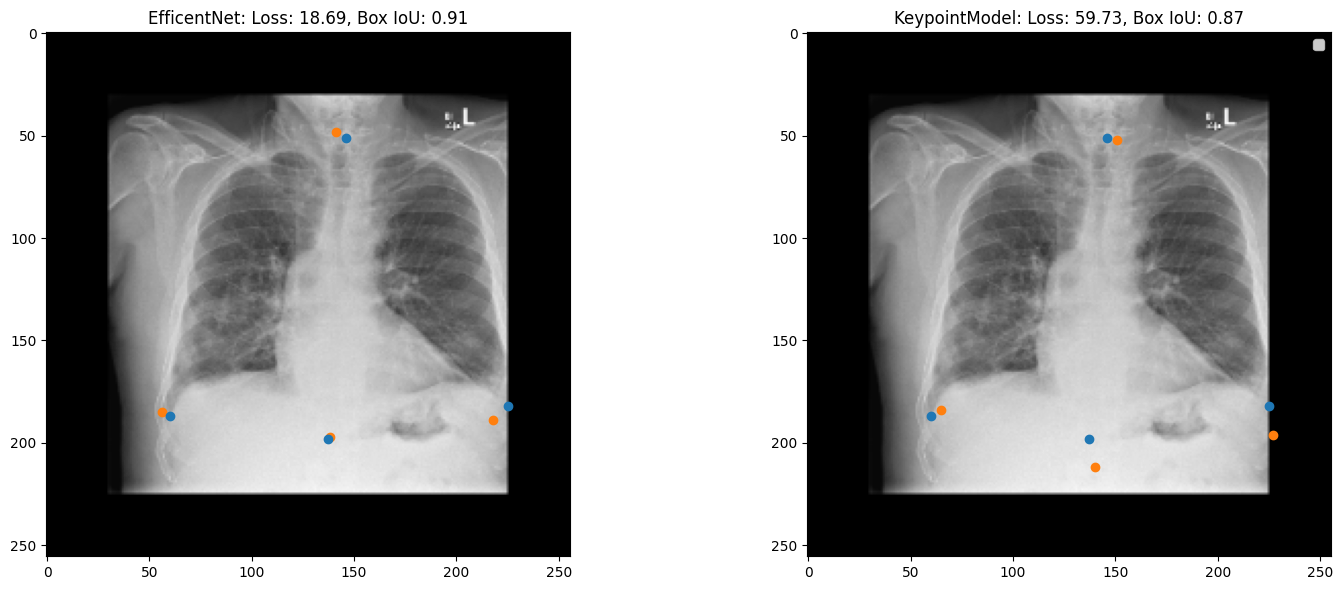

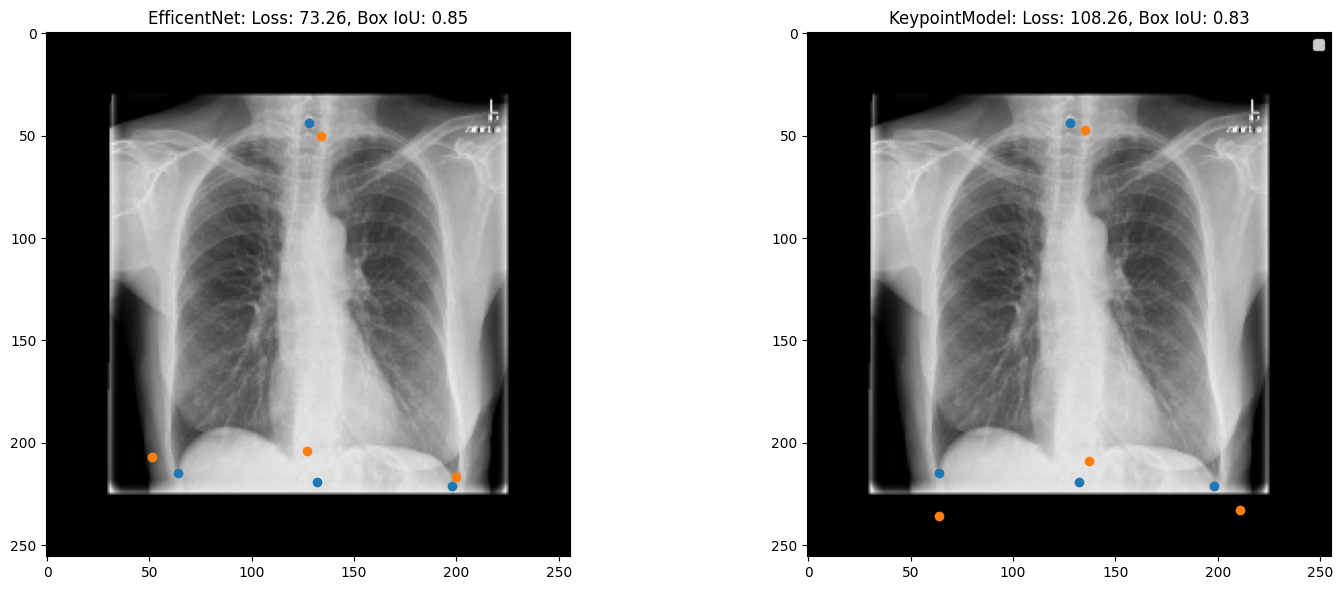

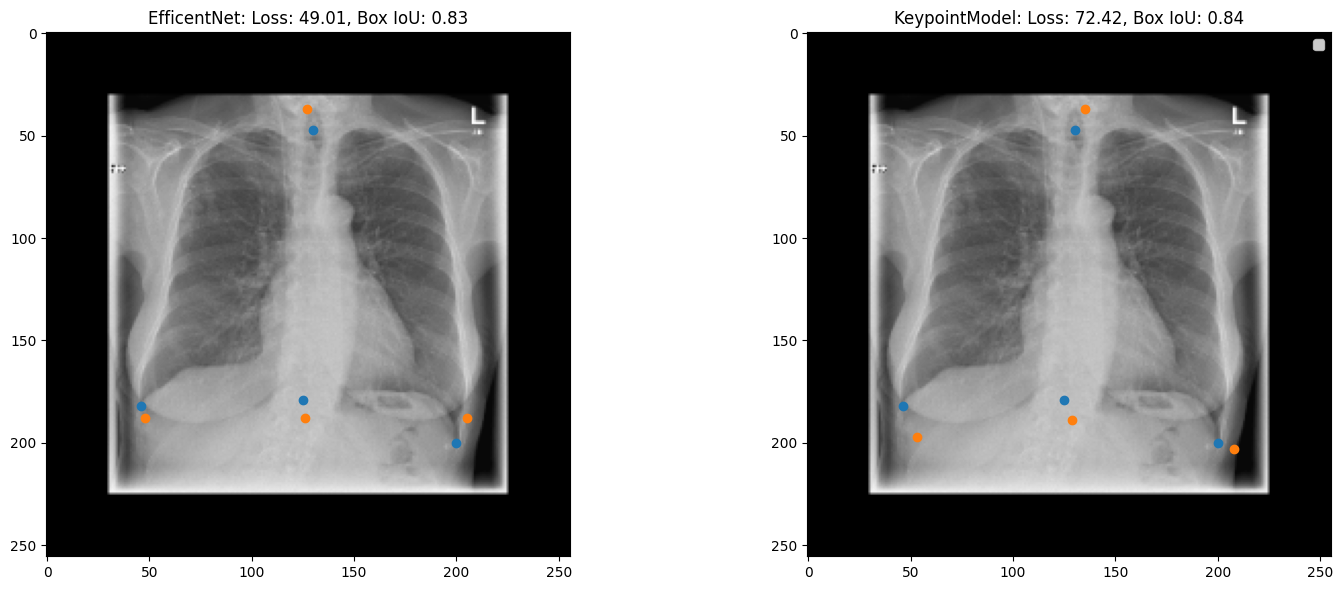

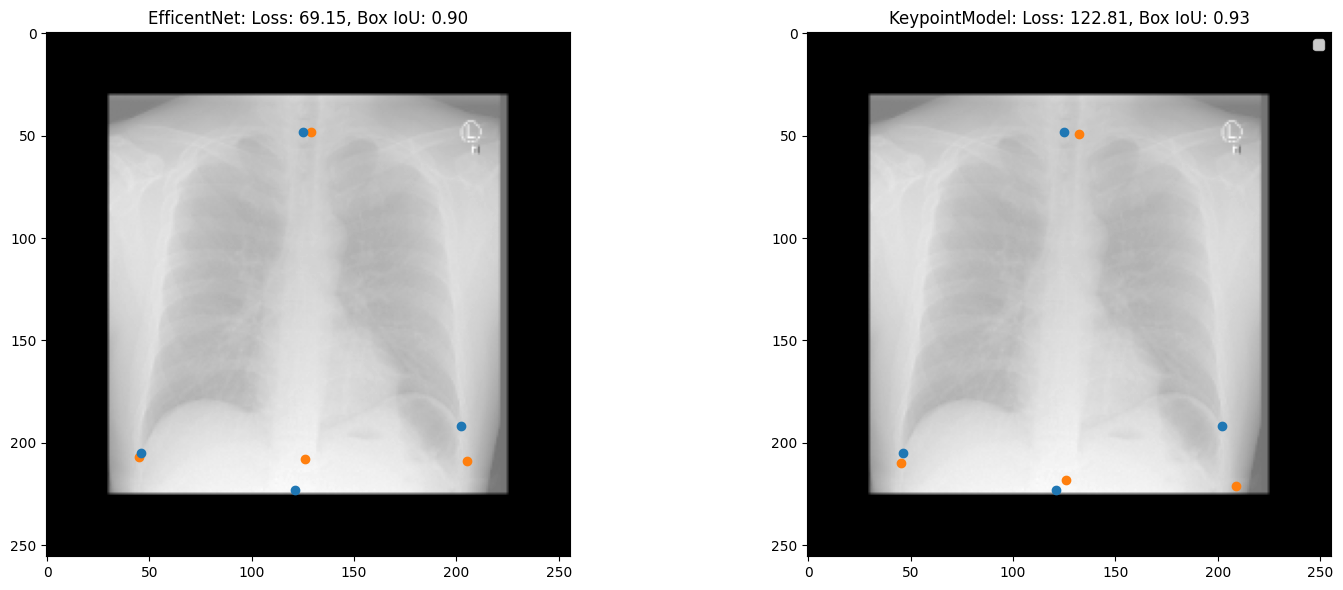

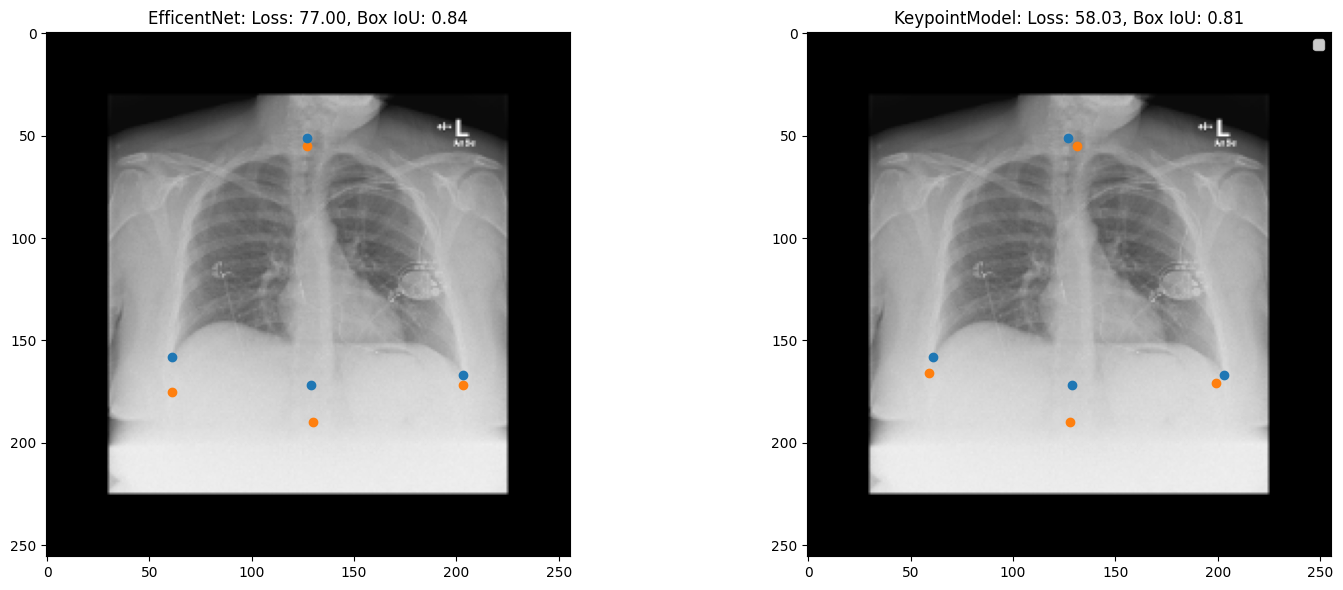

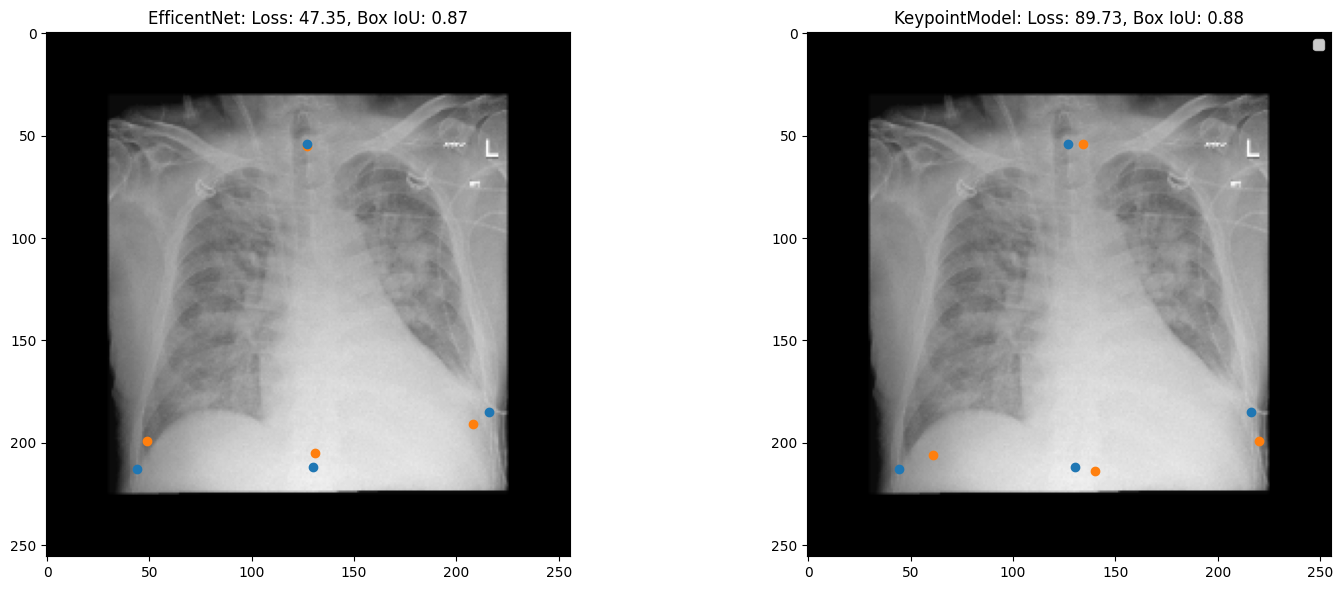

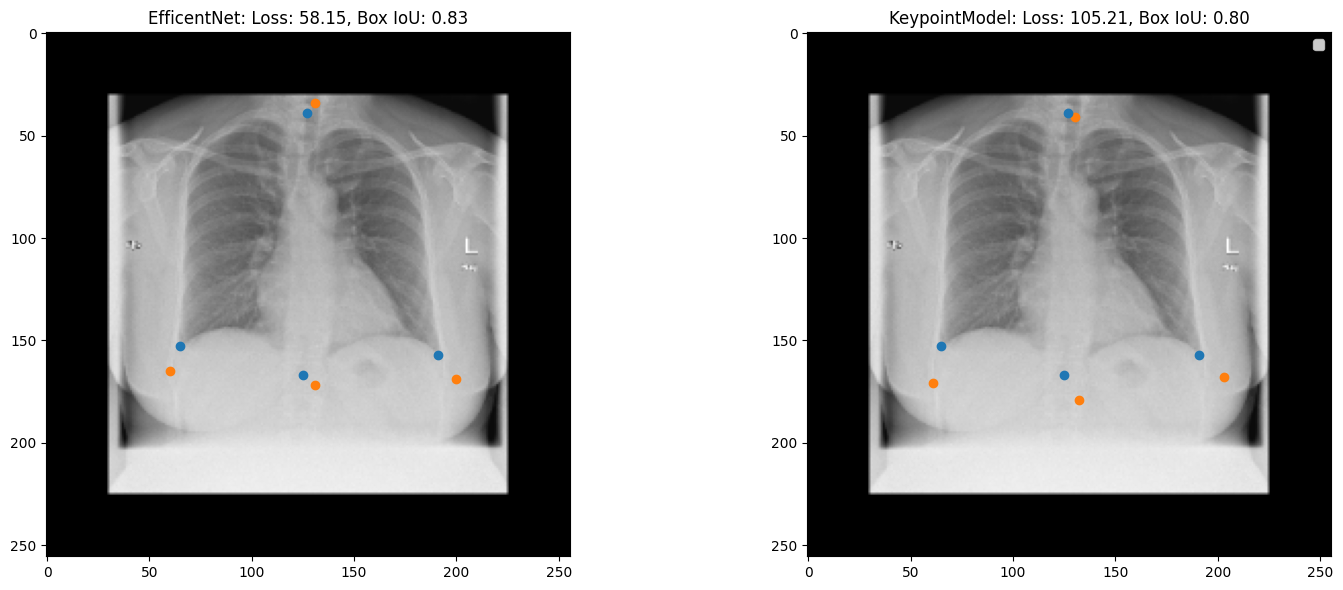

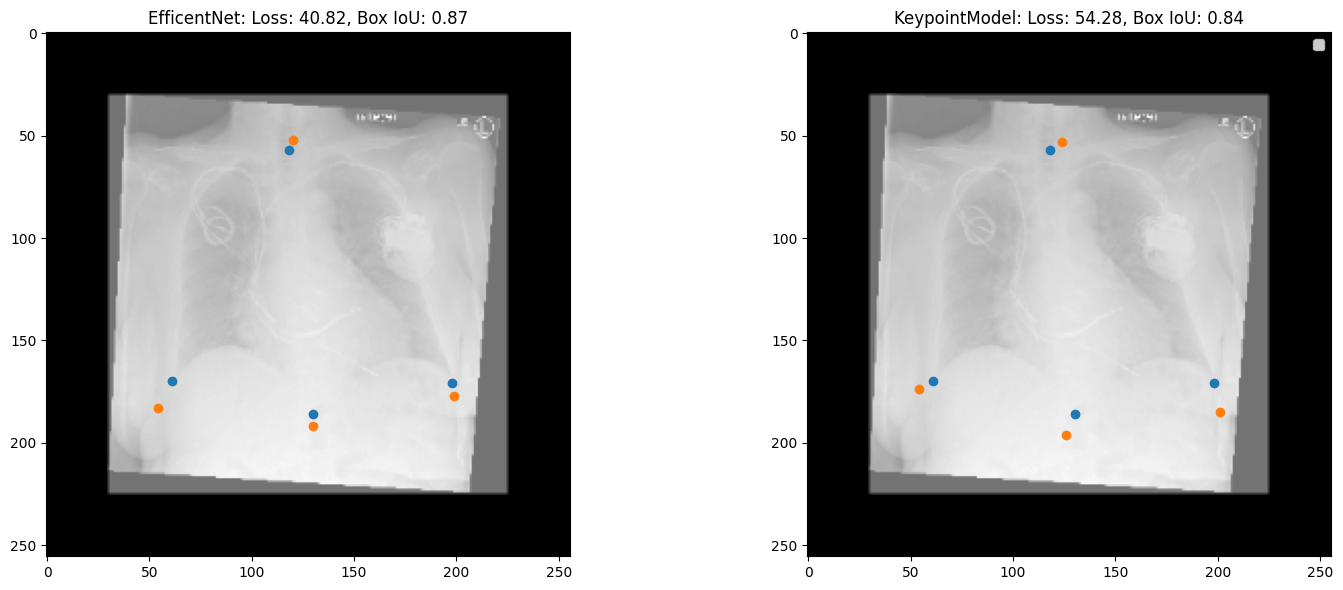

In [6]:
loss_func = nn.MSELoss()

for image, targ in random_loader:
    img_Keyp = image.to(device = DEVICE)
    img_EffNet = img_Keyp.repeat(1, 3, 1, 1)
    target = targ.to(DEVICE)
    pred_EffNet = EffNet(img_EffNet)
    pred_keyp = Keyp(img_Keyp)

    #images
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].imshow(image[0,0], cmap ='gray')
    axs[1].imshow(image[0,0], cmap ='gray')


    boxes_EffNet = []
    kp = targ.squeeze(1).detach().numpy().astype(np.uint8)
    pred_kp = pred_EffNet.cpu().detach().numpy().astype(np.uint8)
    for keypoints in [kp, pred_kp]:
        keypoint_image = torch.zeros(image[0,0].shape)
        for i in range(0,8,2):
            keypoint_image[keypoints[0,i+1],keypoints[0,i]] = 1        
        boxes_EffNet.append(masks_to_boxes(keypoint_image.unsqueeze(0)))

    test_box, pred_box_EffNet = boxes_EffNet[0][0], boxes_EffNet[1][0]
    for i in range(0,8,2):
        axs[0].scatter(pred_kp[0,i],pred_kp[0,i+1], color = 'C1')
        axs[0].scatter(kp[0,i],kp[0,i+1], color = 'C0')
    rect_pred = patches.Rectangle((pred_box_EffNet[0], pred_box_EffNet[1]), pred_box_EffNet[2] - pred_box_EffNet[0],
                                    pred_box_EffNet[3] - pred_box_EffNet[1], linewidth=4, edgecolor='C1', facecolor='none', label='predicted crop')
    rect_test = patches.Rectangle((test_box[0], test_box[1]), test_box[2] - test_box[0],
                                    test_box[3] - test_box[1], linewidth=4, edgecolor='C0', facecolor='none', label='true crop')

    #axs[0].add_patch(rect_pred)
    #axs[0].add_patch(rect_test)
    box_iou = generalized_box_iou(boxes_EffNet[0], boxes_EffNet[1])
    box_iou = torch.nan_to_num(box_iou, 0)
    box_iou = torch.trace(box_iou)
    loss = loss_func(pred_EffNet, target.squeeze(1))
    axs[0].set_title(f'EfficentNet: Loss: {loss:.2f}, Box IoU: {box_iou:.2f}')


    boxes_keyp = []
    kp = targ.squeeze(1).detach().numpy().astype(np.uint8)
    pred_kp = pred_keyp.cpu().detach().numpy().astype(np.uint8)
    for keypoints in [kp, pred_kp]:
        keypoint_image = torch.zeros(image[0,0].shape)
        for i in range(0,8,2):
            keypoint_image[keypoints[0,i+1],keypoints[0,i]] = 1        
        boxes_keyp.append(masks_to_boxes(keypoint_image.unsqueeze(0)))

    test_box, pred_box_keyp = boxes_keyp[0][0], boxes_keyp[1][0]
    for i in range(0,8,2):
        axs[1].scatter(pred_kp[0,i],pred_kp[0,i+1], color = 'C1')
        axs[1].scatter(kp[0,i],kp[0,i+1], color = 'C0')
    rect_pred = patches.Rectangle((pred_box_keyp[0], pred_box_keyp[1]), pred_box_keyp[2] - pred_box_keyp[0],
                                    pred_box_keyp[3] - pred_box_keyp[1], linewidth=4, edgecolor='C1', facecolor='none', label='predicted crop')
    rect_test = patches.Rectangle((test_box[0], test_box[1]), test_box[2] - test_box[0],
                                    test_box[3] - test_box[1], linewidth=4, edgecolor='C0', facecolor='none', label='true crop')

    #axs[1].add_patch(rect_pred)
    #axs[1].add_patch(rect_test)
    box_iou = generalized_box_iou(boxes_keyp[0], boxes_keyp[1])
    box_iou = torch.nan_to_num(box_iou, 0)
    box_iou = torch.trace(box_iou)
    loss = loss_func(pred_keyp, target.squeeze(1))
    axs[1].set_title(f'KeypointModel: Loss: {loss:.2f}, Box IoU: {box_iou:.2f}')


    plt.legend()
    plt.tight_layout()
    plt.show()

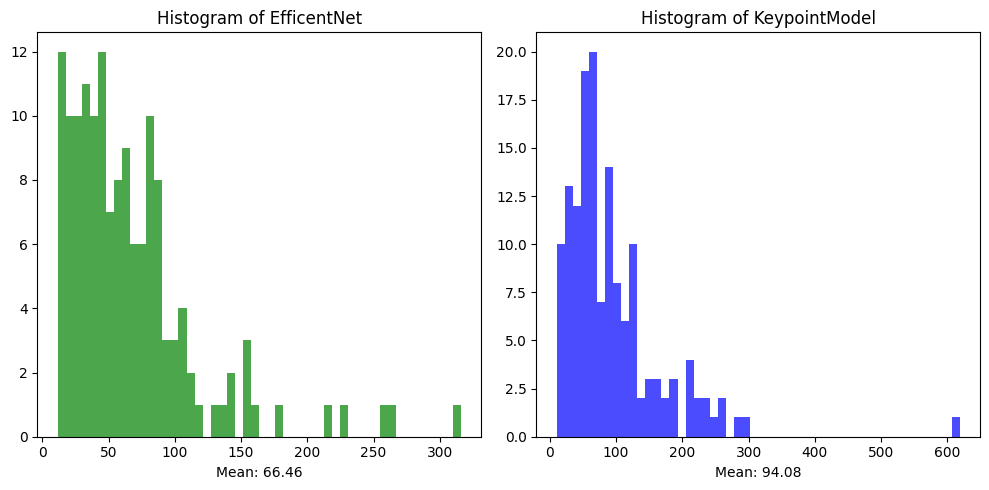

In [7]:
loss_keyp = []
loss_EffNet = []
for image, targ in test_loader:
        for i in range(image.shape[0]):
            img = image[i].to(device = DEVICE).unsqueeze(0)
            target = targ[i].to(DEVICE)
            pred_keyp = Keyp(img)
            pred_EffNet = EffNet(img.repeat(1, 3, 1, 1))
            loss_keyp.append(loss_func(pred_keyp, target.unsqueeze(0).squeeze(1)).item())
            loss_EffNet.append(loss_func(pred_EffNet, target.unsqueeze(0).squeeze(1)).item())


mean_keyp = sum(loss_keyp) / len(loss_keyp)
mean_EffNet = sum(loss_EffNet) / len(loss_EffNet)

# Create a figure and two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# First histogram
axes[1].hist(loss_keyp, bins=50, color='blue', alpha=0.7)
axes[1].set_title('Histogram of KeypointModel')
axes[1].set_xlabel(f'Mean: {mean_keyp:.2f}')

# Second histogram
axes[0].hist(loss_EffNet, bins=50, color='green', alpha=0.7)
axes[0].set_title('Histogram of EfficentNet')
axes[0].set_xlabel(f'Mean: {mean_EffNet:.2f}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [8]:
bigger_400 = [i for i, los in enumerate(loss_EffNet) if los > 200]
bigger_400

[14, 18, 32, 33, 74]

In [9]:
extra_test_loader = DataLoader(test_keypoint_ds,
                    batch_size= 1,
                    num_workers= 0,                      
                    pin_memory= False,
                    shuffle= False)

In [8]:

Own_unet = UNET(
    in_channels=1, 
    out_channels=1, 
    features= [16, 32, 64, 128]).to(DEVICE)

load_checkpoint(Own_unet, r'/home/alex/Documents/new try/Data/Lung Unet/save_states/Own_unet_padding_2.pth.tar') #own_unet_test.pth.tar

=> Loading checkpoint


1


/tmp/ipykernel_393912/1251935705.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


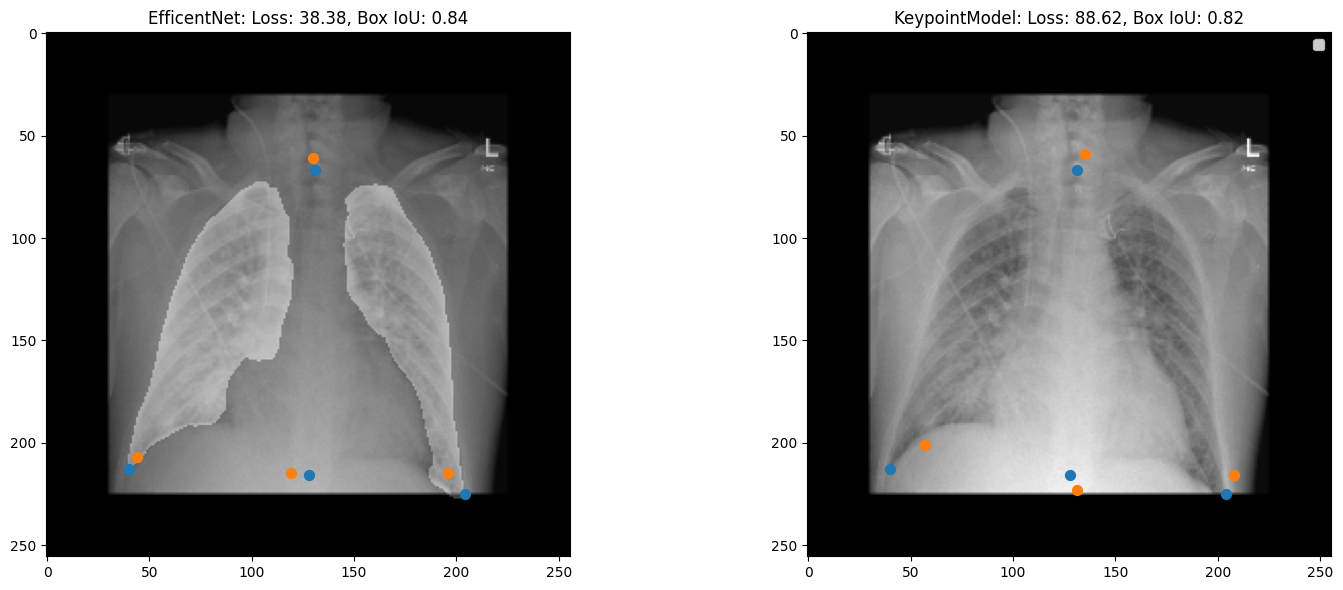

9


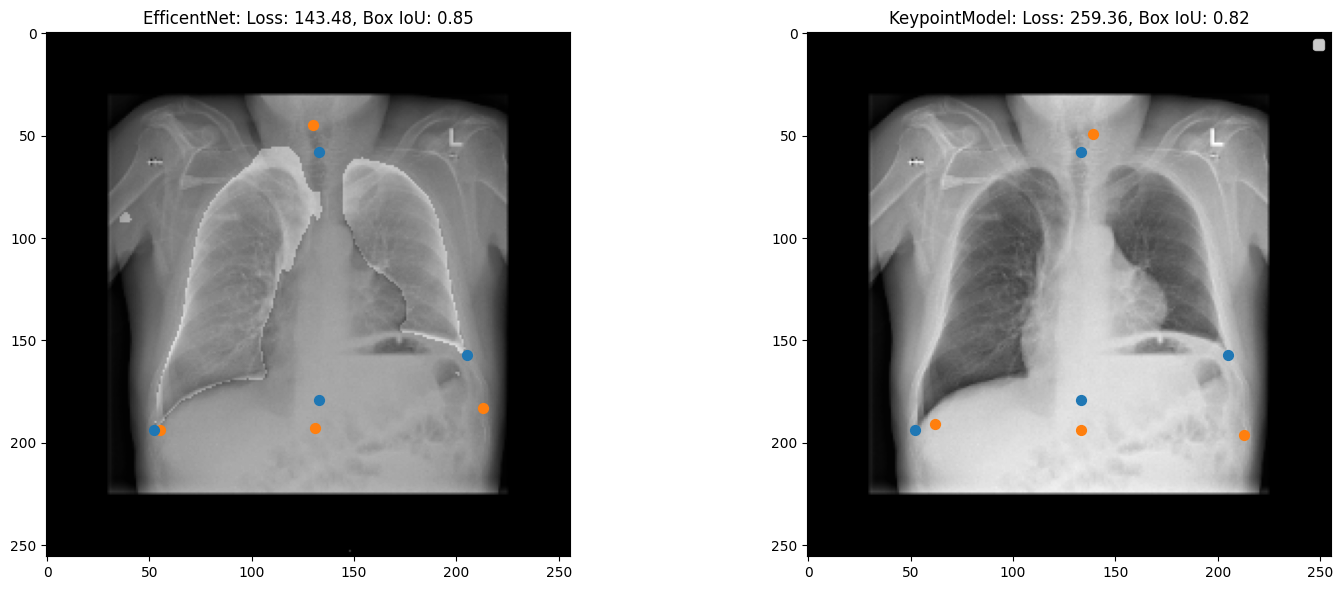

12


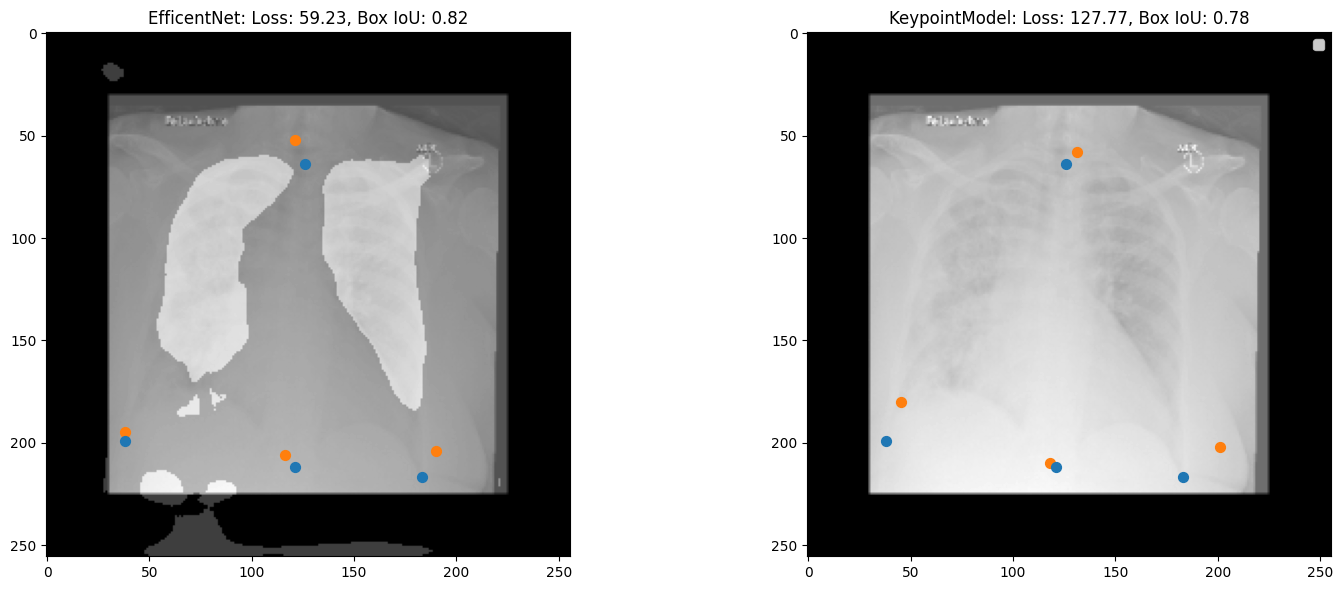

14


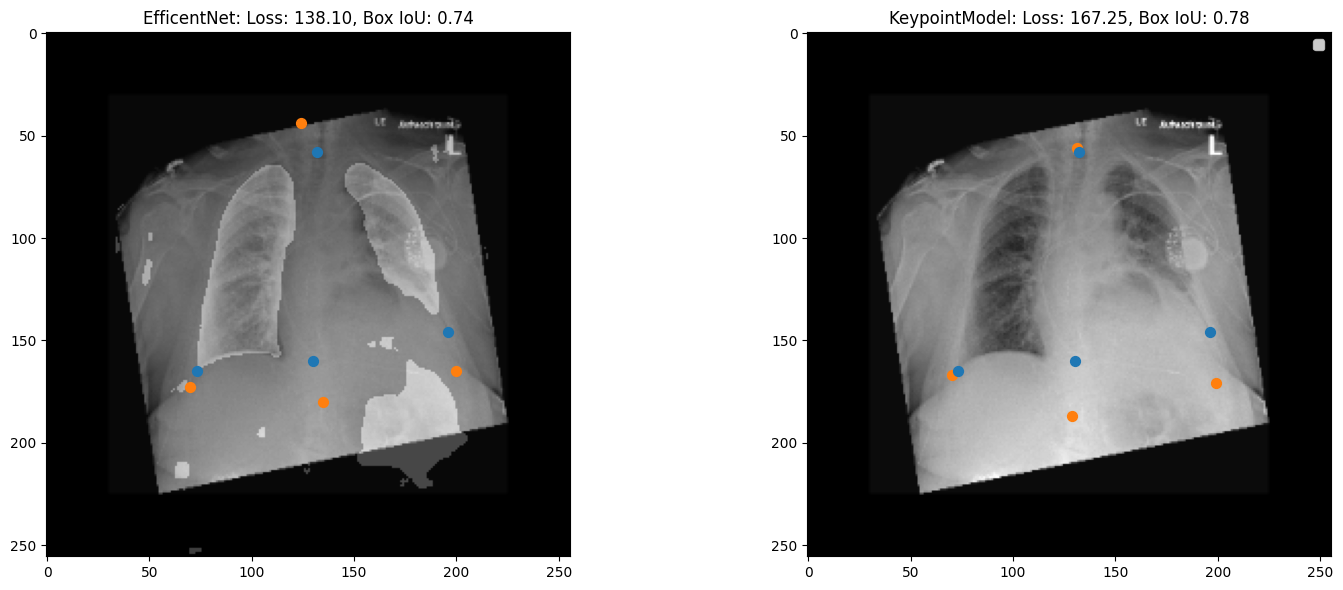

15


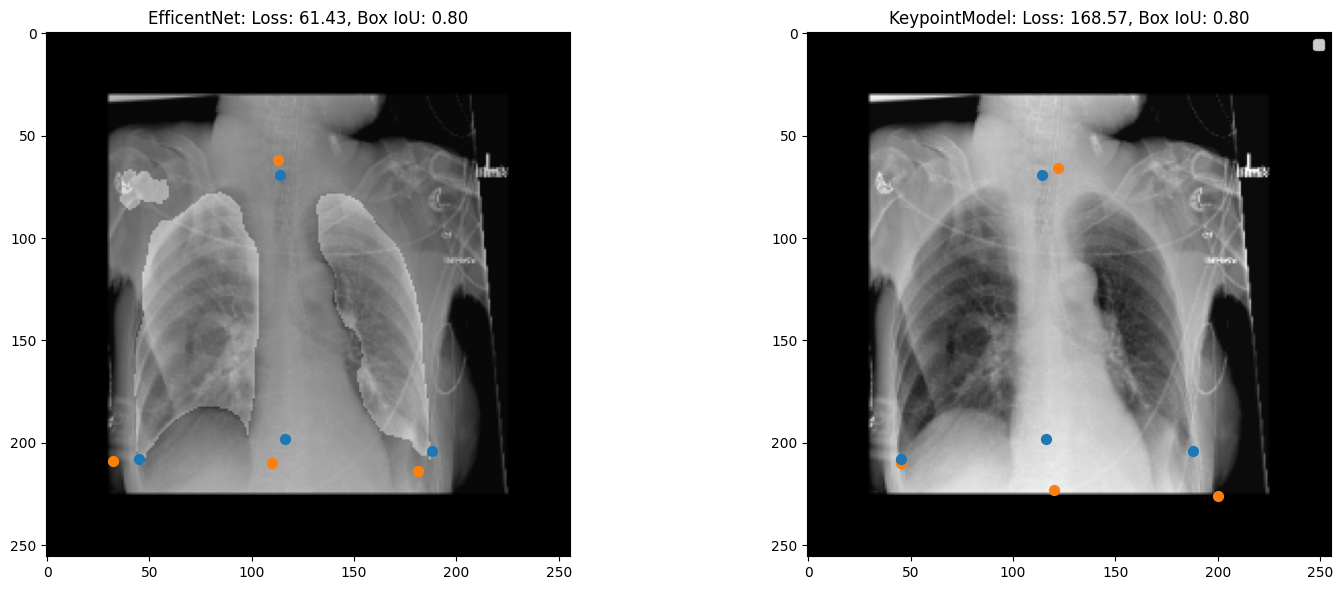

18


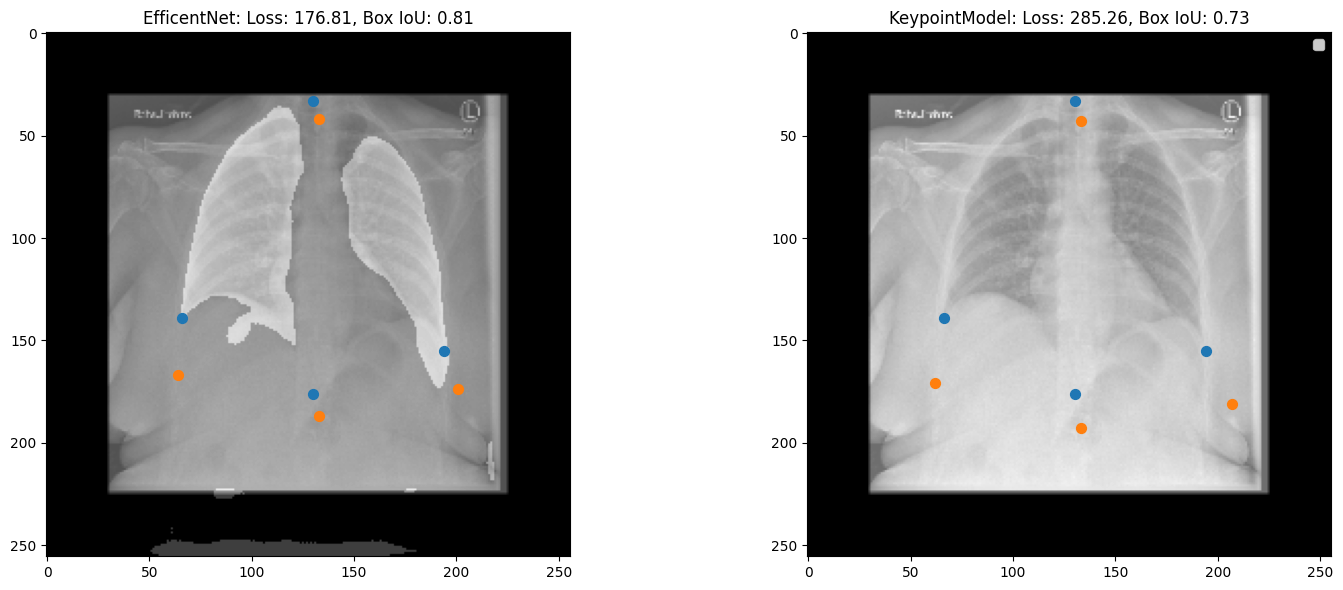

20


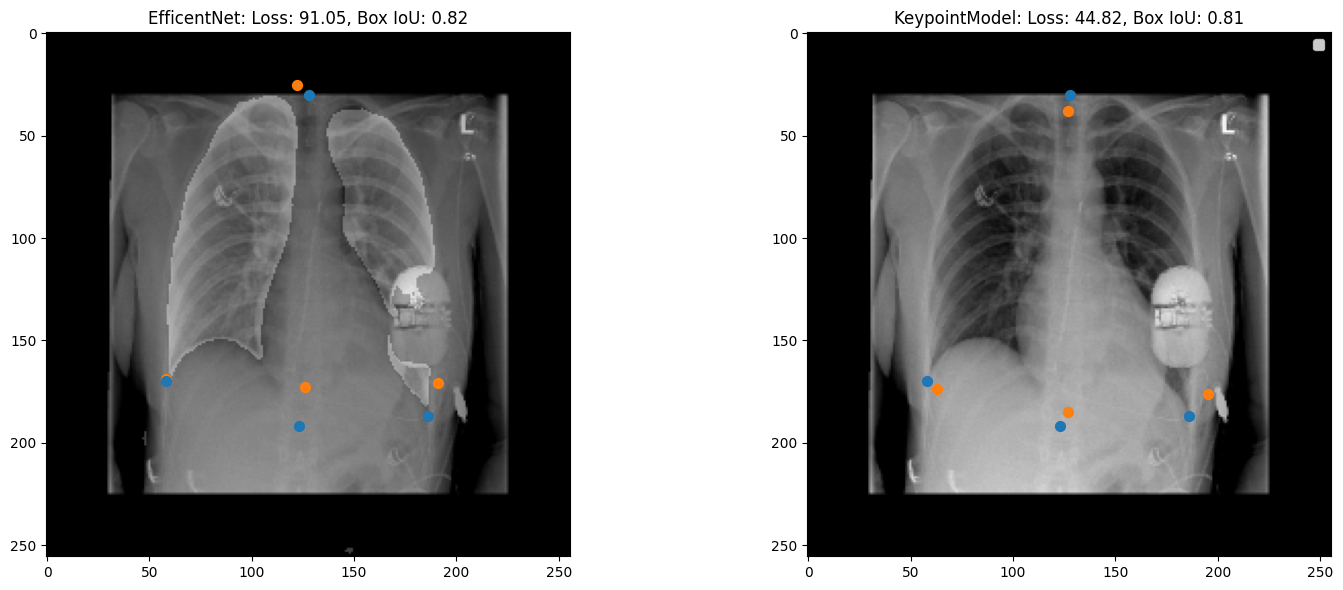

29


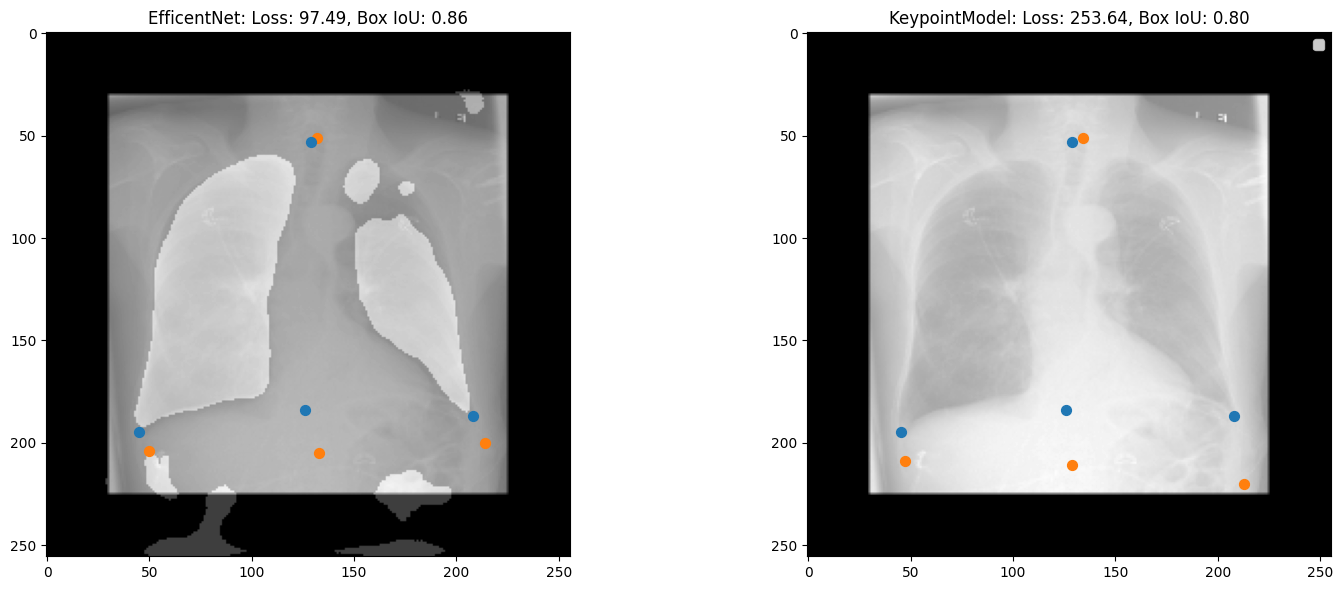

32


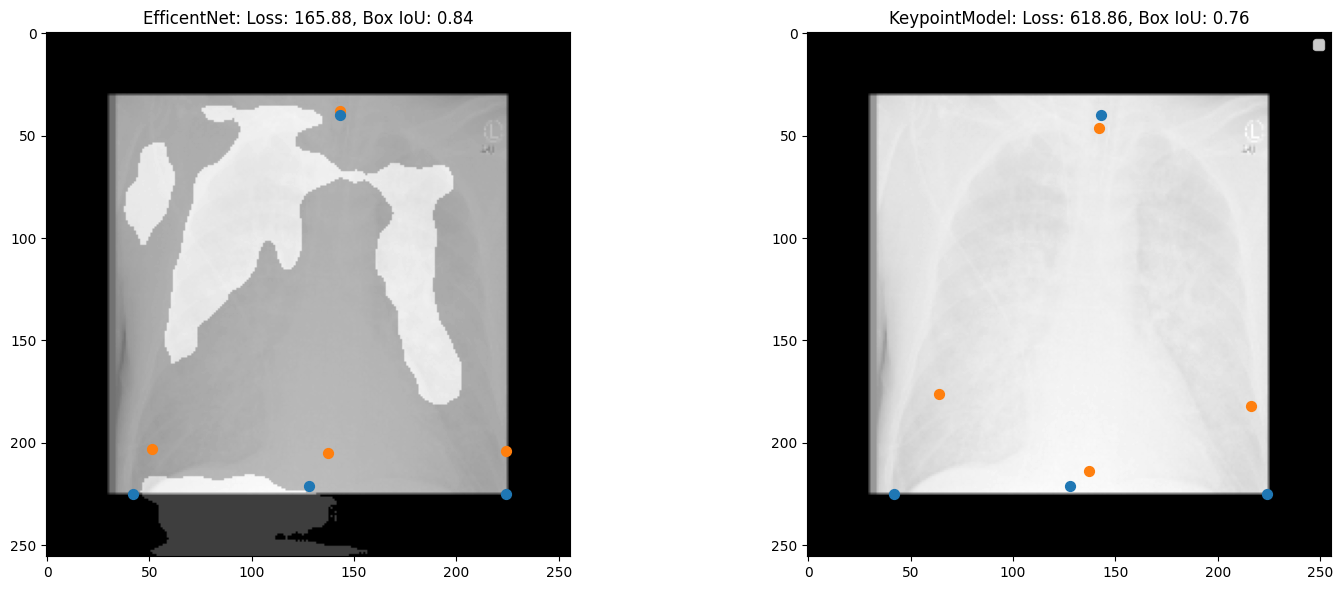

54


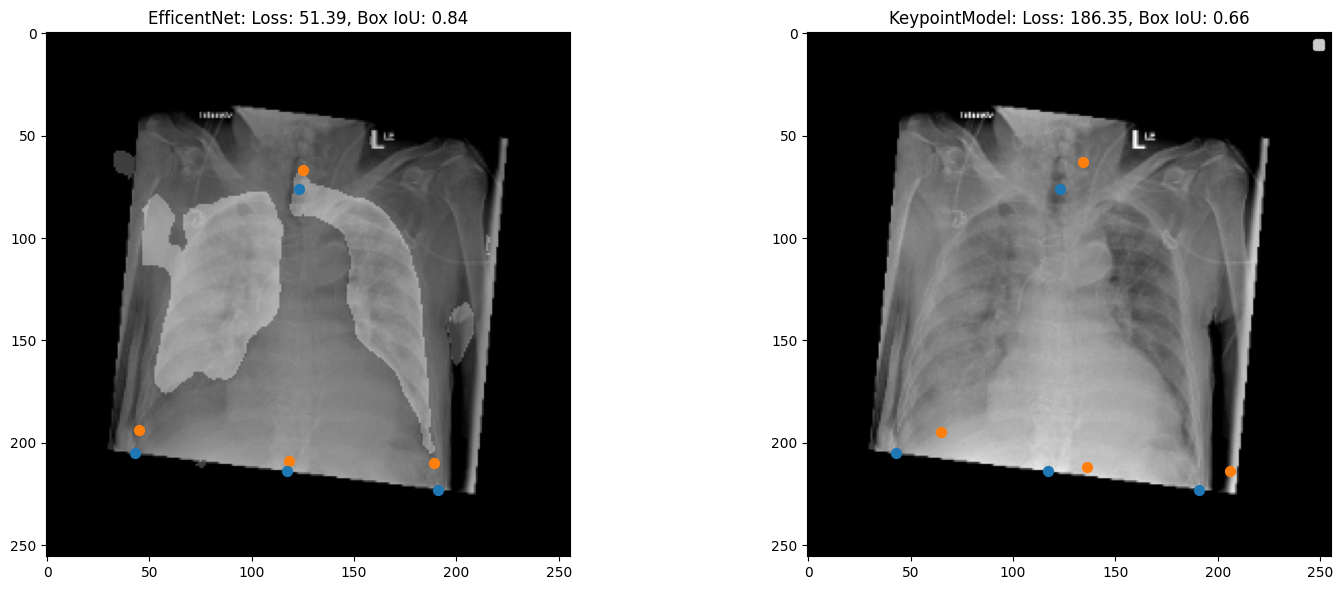

60


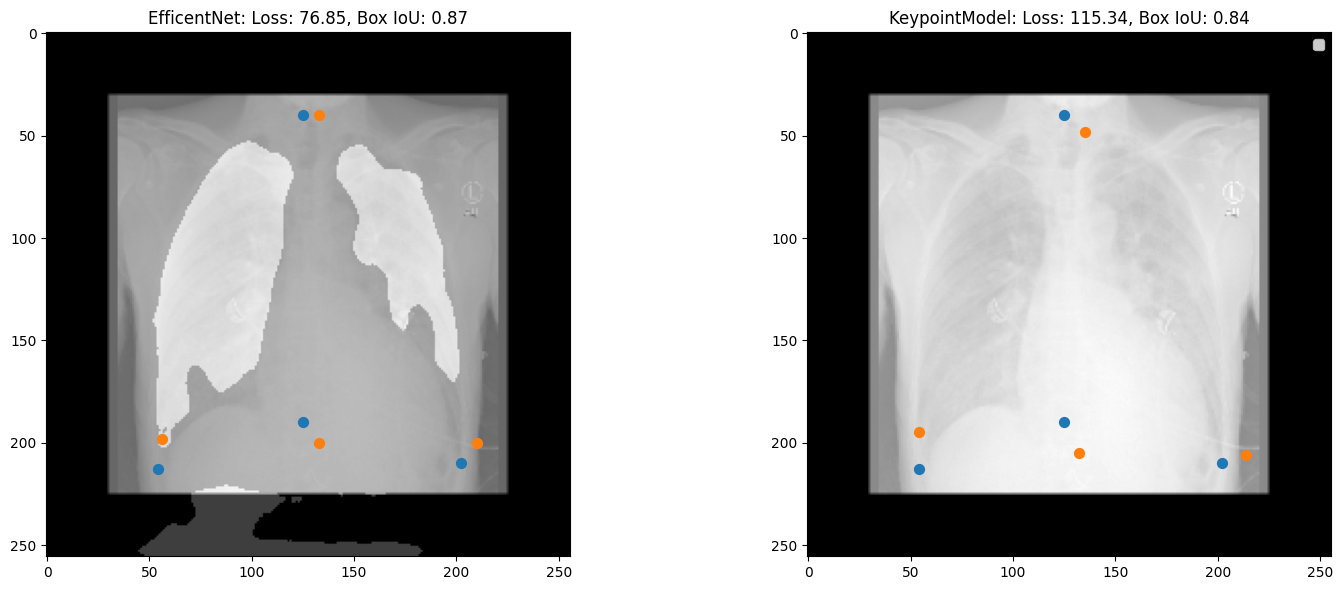

61


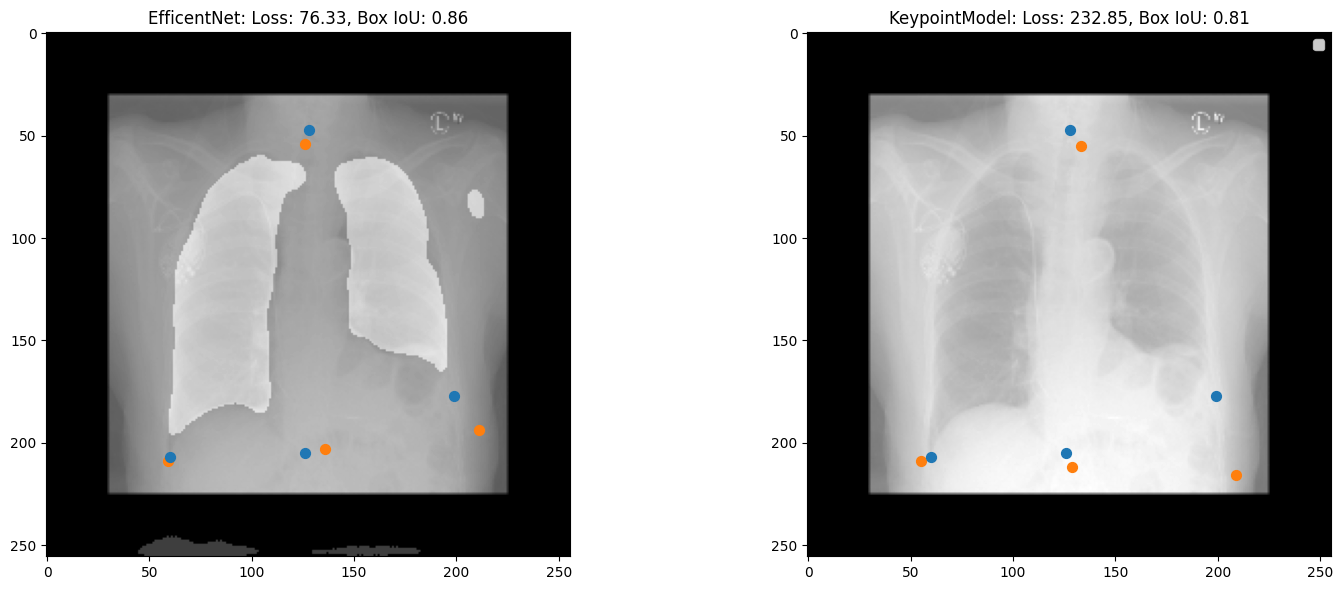

70


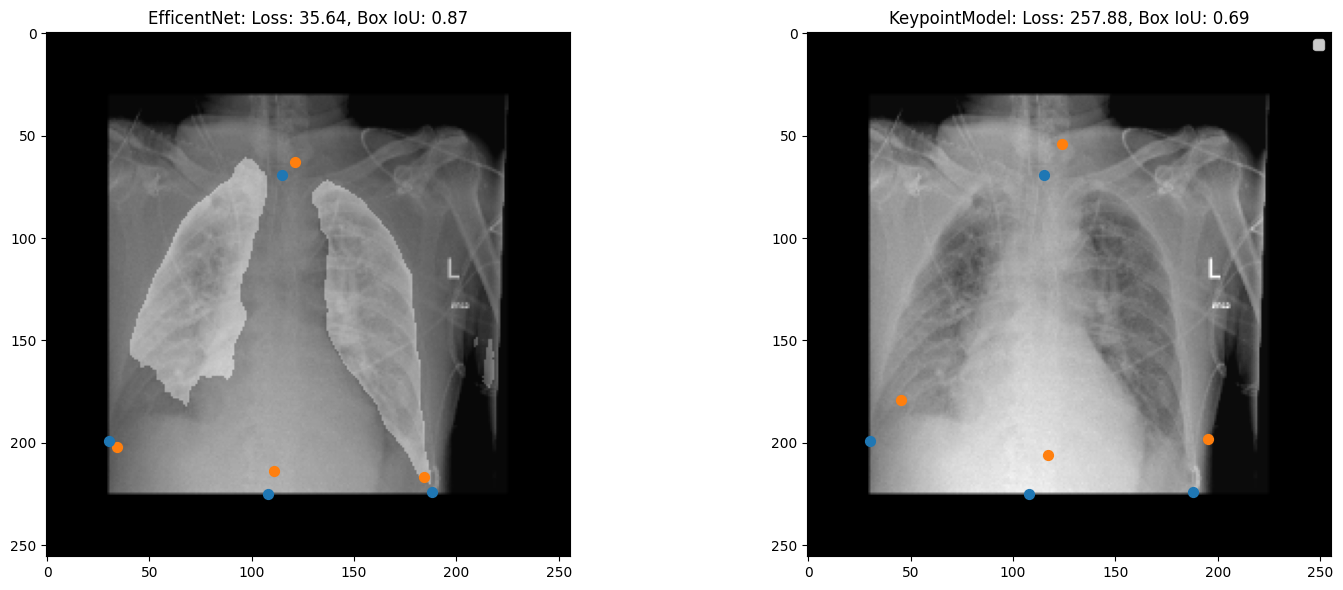

88


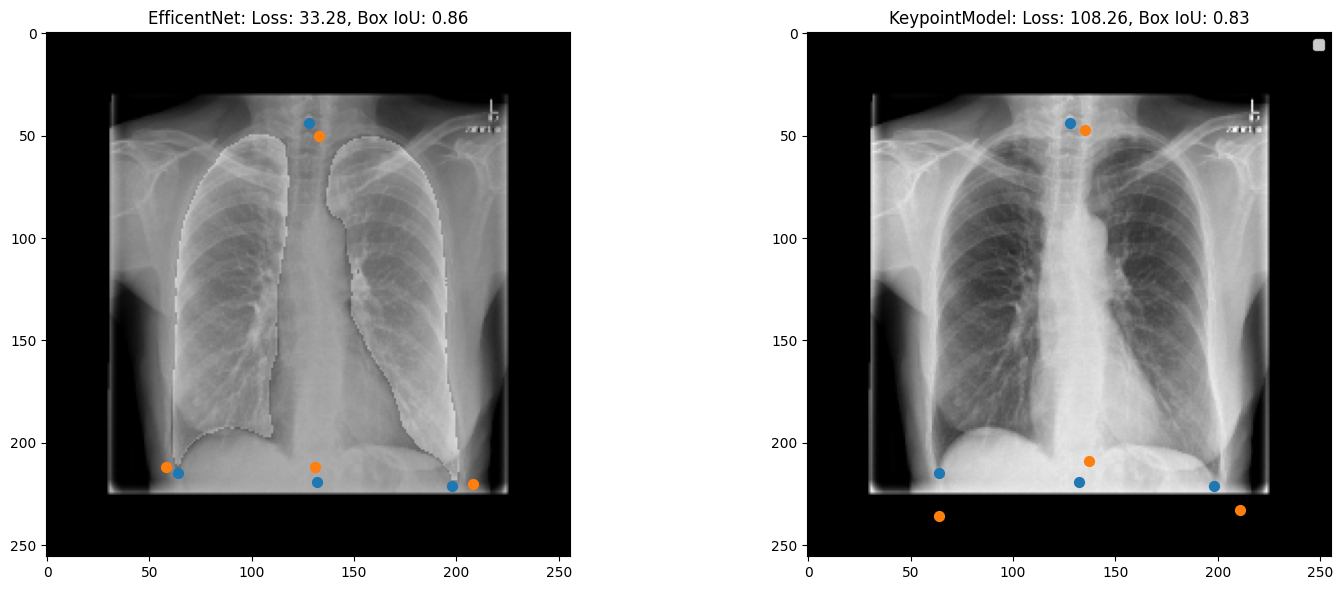

105


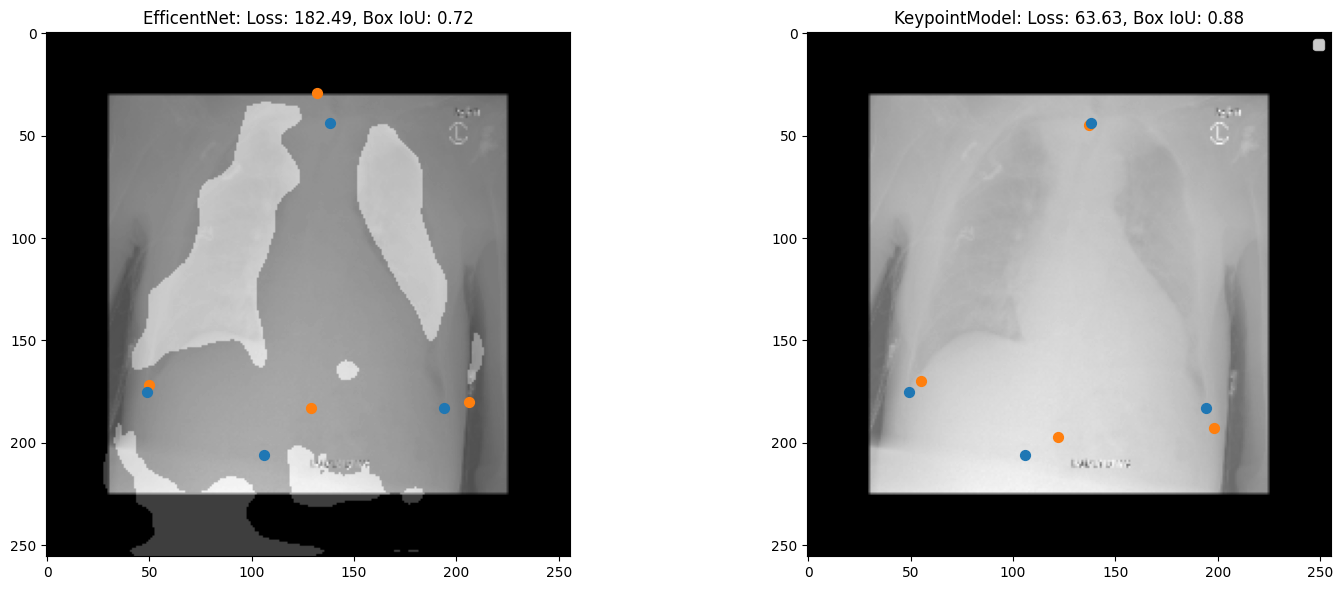

115


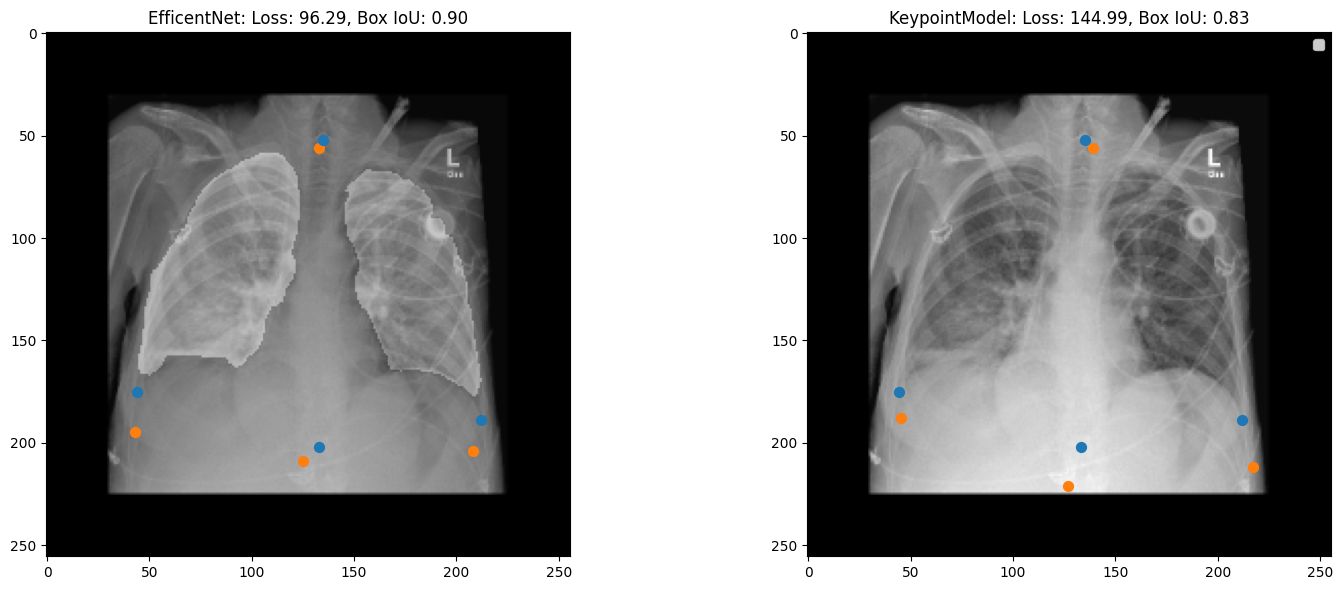

120


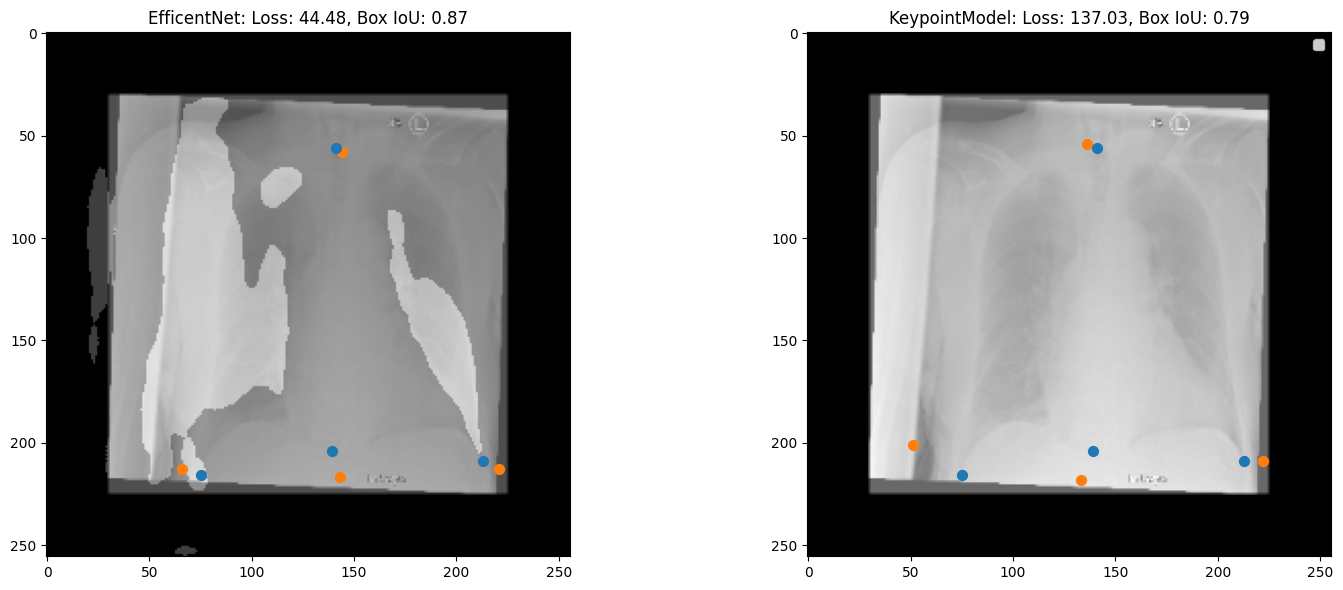

126


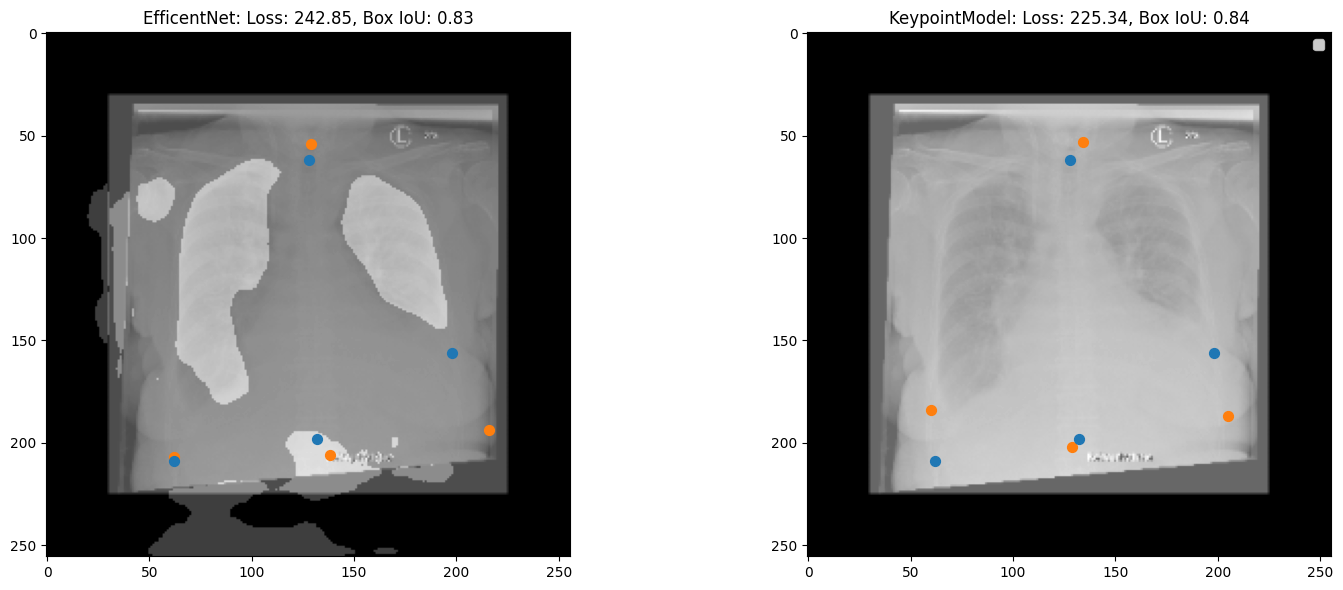

132


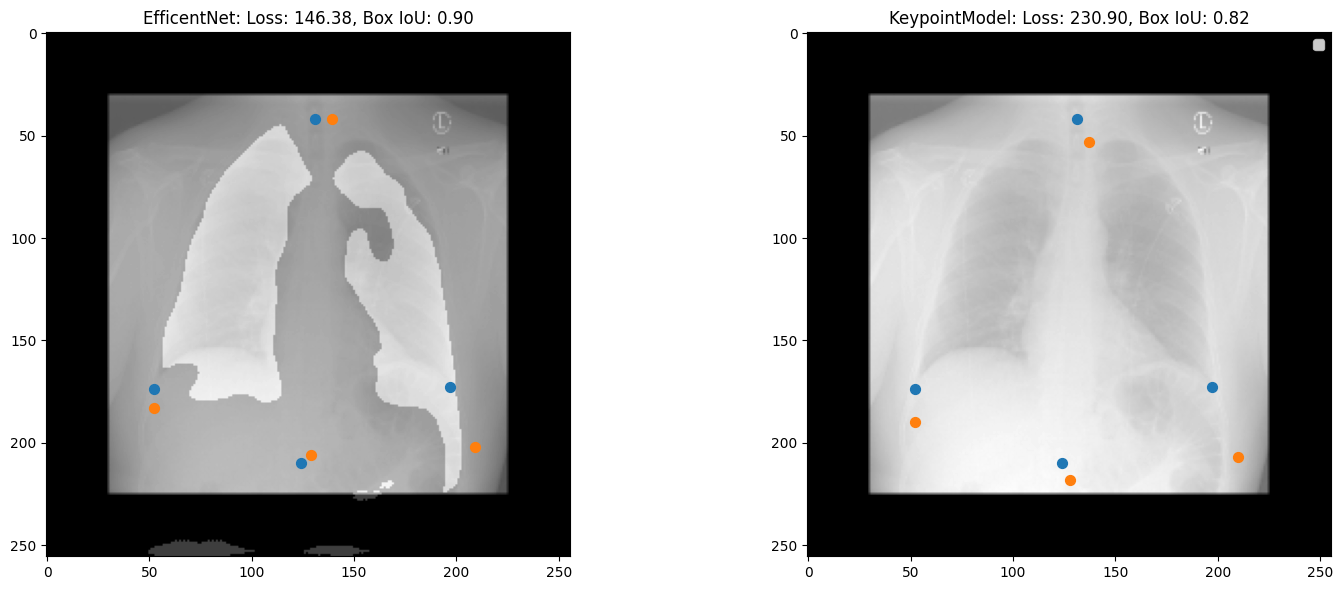

In [10]:
for i, (image, targ) in enumerate(test_loader):
    if i in [1, 9, 12, 14, 15, 18, 20, 29, 32, 54, 60, 61, 70, 88, 105, 115, 120, 126, 132]:
        print(i)
        img_Keyp = image.to(device = DEVICE)
        img_EffNet = img_Keyp.repeat(1, 3, 1, 1)
        target = targ.to(DEVICE)
        pred_EffNet = EffNet(img_EffNet)
        pred_keyp = Keyp(img_Keyp)
        pred_mask = Own_unet(img_Keyp)
        pred_mask = (torch.sigmoid(pred_mask) > 0.5)

        #images
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        axs[0].imshow(image[0,0], cmap ='gray')
        axs[0].imshow(pred_mask[0,0].cpu().detach().numpy(), alpha=0.25, cmap = 'gray') 
        axs[1].imshow(image[0,0], cmap ='gray')


        boxes_EffNet = []
        kp = targ.squeeze(1).detach().numpy().astype(np.uint8)
        pred_kp = pred_EffNet.cpu().detach().numpy().astype(np.uint8)
        for keypoints in [kp, pred_kp]:
            keypoint_image = torch.zeros(image[0,0].shape)
            for i in range(0,8,2):
                keypoint_image[keypoints[0,i+1],keypoints[0,i]] = 1        
            boxes_EffNet.append(masks_to_boxes(keypoint_image.unsqueeze(0)))

        test_box, pred_box_EffNet = boxes_EffNet[0][0], boxes_EffNet[1][0]
        for i in range(0,8,2):
            axs[0].scatter(pred_kp[0,i],pred_kp[0,i+1], color = 'C1', s = 50)
            axs[0].scatter(kp[0,i],kp[0,i+1], color = 'C0', s = 50)
        rect_pred = patches.Rectangle((pred_box_EffNet[0], pred_box_EffNet[1]), pred_box_EffNet[2] - pred_box_EffNet[0],
                                    pred_box_EffNet[3] - pred_box_EffNet[1], linewidth=4, edgecolor='C1', facecolor='none', label='predicted crop')
        rect_test = patches.Rectangle((test_box[0], test_box[1]), test_box[2] - test_box[0],
                                    test_box[3] - test_box[1], linewidth=4, edgecolor='C0', facecolor='none', label='true crop')

        #axs[0].add_patch(rect_pred)
        #axs[0].add_patch(rect_test)
        box_iou = generalized_box_iou(boxes_EffNet[0], boxes_EffNet[1])
        box_iou = torch.nan_to_num(box_iou, 0)
        box_iou = torch.trace(box_iou)
        loss = loss_func(pred_EffNet, target.squeeze(1))
        axs[0].set_title(f'EfficentNet: Loss: {loss:.2f}, Box IoU: {box_iou:.2f}')


        boxes_keyp = []
        kp = targ.squeeze(1).detach().numpy().astype(np.uint8)
        pred_kp = pred_keyp.cpu().detach().numpy().astype(np.uint8)
        for keypoints in [kp, pred_kp]:
            keypoint_image = torch.zeros(image[0,0].shape)
            for i in range(0,8,2):
                keypoint_image[keypoints[0,i+1],keypoints[0,i]] = 1        
            boxes_keyp.append(masks_to_boxes(keypoint_image.unsqueeze(0)))

        test_box, pred_box_keyp = boxes_keyp[0][0], boxes_keyp[1][0]
        for i in range(0,8,2):
            axs[1].scatter(pred_kp[0,i],pred_kp[0,i+1], color = 'C1', s = 50)
            axs[1].scatter(kp[0,i],kp[0,i+1], color = 'C0', s = 50)
        rect_pred = patches.Rectangle((pred_box_keyp[0], pred_box_keyp[1]), pred_box_keyp[2] - pred_box_keyp[0],
                                    pred_box_keyp[3] - pred_box_keyp[1], linewidth=4, edgecolor='C1', facecolor='none', label='predicted crop')
        rect_test = patches.Rectangle((test_box[0], test_box[1]), test_box[2] - test_box[0],
                                    test_box[3] - test_box[1], linewidth=4, edgecolor='C0', facecolor='none', label='true crop')

        #axs[1].add_patch(rect_pred)
        #axs[1].add_patch(rect_test)
        box_iou = generalized_box_iou(boxes_keyp[0], boxes_keyp[1])
        box_iou = torch.nan_to_num(box_iou, 0)
        box_iou = torch.trace(box_iou)
        loss = loss_func(pred_keyp, target.squeeze(1))
        axs[1].set_title(f'KeypointModel: Loss: {loss:.2f}, Box IoU: {box_iou:.2f}')


        plt.legend()
        plt.tight_layout()
        plt.show()
            

Test check

In [ ]:
model.eval()
loss = 0
IoU = 0
for image, targ in test_loader:
        img = image.to(device = DEVICE)
        target = targ.to(DEVICE)
        pred = model(img)
        loss += loss_func(pred, target.squeeze(1))
        IoU += keypoints_IoU_mult(image, targ.squeeze(1), pred)
        pred = pred[0].to('cpu').detach().numpy()
        plt.imshow(image[0][0], cmap='gray')
        for i in range(0, 8, 2):
                scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
                scatter2 = plt.scatter(targ[0,0,i], targ[0,0,i+1], color = 'C0')
        scatter1.set_label('predicted')
        scatter2.set_label('original')
        plt.legend()
        plt.show()
print('MSE:', loss.item()/len(test_loader))
print('Box IoU:', IoU.item()/len(test_loader.dataset))

Histogram of errors

In [ ]:
del loss, pred
torch.cuda.empty_cache()  

In [ ]:
model.eval()
loss = []
for image, targ in test_loader:
        for i in range(image.shape[0]):
            img = image[i].to(device = DEVICE).unsqueeze(0)
            target = targ[i].to(DEVICE)
            pred = model(img)
            loss.append(loss_func(pred, target.unsqueeze(0).squeeze(1)).item())
print(loss)
plt.hist(loss, bins = 50)

show example with highest loss

In [ ]:
indexes = [i for i, loss in enumerate(loss) if loss > 600]

subset = Subset(test_keypoint_ds, indexes)

subset_loader = DataLoader(subset,
                          batch_size= 1,
                          num_workers= NUM_WORKERS,
                          pin_memory= PIN_MEMORY,
                          shuffle= False)

In [ ]:
for image, kp in subset_loader:
    img = image.to(device = DEVICE)
    target = kp.to(DEVICE)
    pred = model(img)
    pred = pred[0].to('cpu').detach().numpy()
    plt.imshow(image[0][0], cmap='gray')
    for i in range(0, 8, 2):
        scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
        scatter2 = plt.scatter(kp[0,0,i], kp[0,0,i+1], color = 'C0')
    scatter1.set_label('predicted')
    scatter2.set_label('original')
    plt.legend()
    plt.show()

In [ ]:
from torch.utils.data import Subset

# Create a subset of the dataset using these indexes
subset = Subset(dataset, indexes)

# Create a DataLoader for this subset
subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

In [ ]:
test_image_path = r'/home/alex/Documents/new try/Data/Studie_daten/Bilder_stehen/image_58.png' #r'/home/alex/Documents/new try/Lung Unet/data/test/images/CHNCXR_0002_0.png'


Test acc and max error examples